In [1]:
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/25_여름방학/삼성_공모전"

/content/drive/MyDrive/25_여름방학/삼성_공모전


In [4]:
!pip install redis ray optuna wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.1 MB/s eta 0:00:00


In [5]:
!pip install redis ray optuna wandb pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 46.0 MB/s eta 0:00:00


In [20]:
# Complete Autonomous AI Agent Architecture for SEM Depth Mapping
# Multi-Agent System with A2A Communication and MCP Protocol
%%writefile mcp_integrated.py

import asyncio
import uuid
import json
import logging
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
from dataclasses import dataclass, asdict
from enum import Enum
import redis
import ray
from pathlib import Path
import cv2
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import glob # <-- 이 줄 추가
import PIL  # <-- 이 줄도 추가
import optuna
import wandb
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')
# import warnings 바로 아래에 추가
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# =============================================================================
# MCP (Multi-agent Collaboration Protocol) Framework
# =============================================================================

class MessageType(Enum):
    REQUEST = "request"
    RESPONSE = "response"
    NOTIFICATION = "notification"
    QUERY = "query"
    UPDATE = "update"
    HEARTBEAT = "heartbeat"

class Priority(Enum):
    LOW = 1
    MEDIUM = 2
    HIGH = 3
    CRITICAL = 4

@dataclass
class MCPMessage:
    sender_id: str
    receiver_id: str
    message_type: MessageType
    payload: Dict[str, Any]
    priority: Priority = Priority.MEDIUM
    timestamp: str = None
    correlation_id: str = None
    session_id: str = None

    def __post_init__(self):
        if self.timestamp is None:
            self.timestamp = datetime.now().isoformat()
        if self.correlation_id is None:
            self.correlation_id = str(uuid.uuid4())
        if self.session_id is None:
            self.session_id = str(uuid.uuid4())

class MCPCommunicationManager:
    def __init__(self, redis_host='localhost', redis_port=6379):
        self.redis_client = redis.Redis(host=redis_host, port=redis_port, decode_responses=True)
        self.agents = {}
        self.message_queue = asyncio.Queue()
        self.running = False

    async def register_agent(self, agent):
        self.agents[agent.agent_id] = agent
        await self.send_notification(agent.agent_id, "system", {"status": "registered"})

    async def send_message(self, message: MCPMessage):
        message_json = json.dumps(asdict(message))
        channel = f"agent_{message.receiver_id}"
        self.redis_client.publish(channel, message_json)

    async def send_notification(self, sender_id: str, receiver_id: str, payload: Dict):
        message = MCPMessage(
            sender_id=sender_id,
            receiver_id=receiver_id,
            message_type=MessageType.NOTIFICATION,
            payload=payload
        )
        await self.send_message(message)

    async def broadcast_message(self, sender_id: str, payload: Dict):
        for agent_id in self.agents.keys():
            if agent_id != sender_id:
                await self.send_notification(sender_id, agent_id, payload)

# =============================================================================
# Base Agent Class
# =============================================================================

class BaseAgent:
    def __init__(self, agent_id: str, agent_type: str, comm_manager: MCPCommunicationManager):
        self.agent_id = agent_id
        self.agent_type = agent_type
        self.comm_manager = comm_manager
        self.knowledge_base = {}
        self.performance_history = []
        self.running = False
        self.logger = logging.getLogger(f"{agent_type}_{agent_id}")

    async def start(self):
        self.running = True
        await self.comm_manager.register_agent(self)
        await self.initialize()

    async def stop(self):
        self.running = False
        await self.cleanup()

    async def initialize(self):
        """Override in subclasses"""
        pass

    async def cleanup(self):
        """Override in subclasses"""
        pass

    async def process_message(self, message: MCPMessage):
        """Override in subclasses to handle specific message types"""
        pass

    async def send_request(self, receiver_id: str, action: str, parameters: Dict):
        message = MCPMessage(
            sender_id=self.agent_id,
            receiver_id=receiver_id,
            message_type=MessageType.REQUEST,
            payload={"action": action, "parameters": parameters}
        )
        await self.comm_manager.send_message(message)

    async def send_response(self, original_message: MCPMessage, result: Dict):
        response = MCPMessage(
            sender_id=self.agent_id,
            receiver_id=original_message.sender_id,
            message_type=MessageType.RESPONSE,
            payload=result,
            correlation_id=original_message.correlation_id
        )
        await self.comm_manager.send_message(response)

# =============================================================================
# Data Structures and Models
# =============================================================================

class SEMDataset(Dataset):
    def __init__(self, sem_path: str, depth_path: str = None, transform=None):
        self.sem_path = Path(sem_path)
        self.depth_path = Path(depth_path) if depth_path else None
        self.transform = transform
        self.sem_files = list(self.sem_path.glob("*.png")) + list(self.sem_path.glob("*.jpg"))

    def __len__(self):
        return len(self.sem_files)

    def __getitem__(self, idx):
        sem_file = self.sem_files[idx]
        sem_image = cv2.imread(str(sem_file), cv2.IMREAD_GRAYSCALE)
        sem_image = torch.from_numpy(sem_image).float().unsqueeze(0) / 255.0

        if self.depth_path:
            depth_file = self.depth_path / sem_file.name
            if depth_file.exists():
                depth_image = cv2.imread(str(depth_file), cv2.IMREAD_GRAYSCALE)
                depth_image = torch.from_numpy(depth_image).float().unsqueeze(0) / 255.0
            else:
                depth_image = torch.zeros_like(sem_image)
        else:
            depth_image = torch.zeros_like(sem_image)

        if self.transform:
            sem_image = self.transform(sem_image)
            depth_image = self.transform(depth_image)

        return {"sem": sem_image, "depth": depth_image, "filename": sem_file.name}

class TransformedDataset(Dataset):              #Transform이 있을경우, SEM영상과 Depth Map에 동일한 Transform을 적용해야 도메인을 유지한 채 학습
    def __init__(self, sem_path_list, depth_path_list, transform = None):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        self.transform = transform

    def __getitem__(self, index):
        sem_path = self.sem_path_list[index]
        sem_img = PIL.Image.open(sem_path).convert("L")
        if(self.transform):                                                     # transform 진행
            sem_img = self.transform(sem_img)
        sem_img = np.array(sem_img)
        sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
        sem_img = sem_img / 255.

        if self.depth_path_list is not None:
            depth_path = self.depth_path_list[index]
            depth_img = PIL.Image.open(depth_path).convert("L")
            if(self.transform):                                                 # transform 진행
                depth_img = self.transform(depth_img)
            depth_img = np.array(depth_img)
            depth_img = np.expand_dims(depth_img, axis=-1).transpose(2,0,1)
            depth_img = depth_img / 255.

            return torch.Tensor(sem_img), torch.Tensor(depth_img)


        else:
            img_name = sem_path.split('/')[-1]

            return torch.Tensor(sem_img), img_name                              # B,C,H,W


    def __len__(self):
        return len(self.sem_path_list)


# Advanced U-Net Architecture
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.attention = nn.MultiheadAttention(out_channels, 8)

    def forward(self, x):
        b, c, h, w = x.shape
        x = self.conv(x)
        x_flat = x.view(b, c, -1).permute(2, 0, 1)
        attn_out, _ = self.attention(x_flat, x_flat, x_flat)
        return attn_out.permute(1, 2, 0).view(b, c, h, w)

class AdvancedUNet(LightningModule):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.features = features
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        # Encoder
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Bottleneck with attention
        self.bottleneck = nn.Sequential(
            self._block(features[-1], features[-1] * 2),
            AttentionBlock(features[-1] * 2, features[-1] * 2)
        )

        # Decoder
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, 2, 2))
            self.decoder.append(self._block(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, 1)
        self.loss_fn = self._create_loss()

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _create_loss(self):
        class CombinedLoss(nn.Module):
            def __init__(self):
                super().__init__()
                self.mse = nn.MSELoss()
                self.l1 = nn.L1Loss()

            def forward(self, pred, target):
                mse_loss = self.mse(pred, target)
                l1_loss = self.l1(pred, target)
                ssim_loss = 1 - self._ssim(pred, target)
                return 0.4 * mse_loss + 0.3 * l1_loss + 0.3 * ssim_loss

            def _ssim(self, pred, target, window_size=11):
                # Simplified SSIM implementation
                mu1 = F.avg_pool2d(pred, window_size, 1, padding=window_size//2)
                mu2 = F.avg_pool2d(target, window_size, 1, padding=window_size//2)
                mu1_sq = mu1.pow(2)
                mu2_sq = mu2.pow(2)
                mu1_mu2 = mu1 * mu2

                sigma1_sq = F.avg_pool2d(pred * pred, window_size, 1, padding=window_size//2) - mu1_sq
                sigma2_sq = F.avg_pool2d(target * target, window_size, 1, padding=window_size//2) - mu2_sq
                sigma12 = F.avg_pool2d(pred * target, window_size, 1, padding=window_size//2) - mu1_mu2

                C1 = 0.01 ** 2
                C2 = 0.03 ** 2

                ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
                return ssim_map.mean()

        return CombinedLoss()

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx//2]
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](x)

        return torch.sigmoid(self.final_conv(x))

    def training_step(self, batch, batch_idx):
        sem, depth = batch["sem"], batch["depth"]
        pred_depth = self(sem)
        loss = self.loss_fn(pred_depth, depth)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        sem, depth = batch["sem"], batch["depth"]
        pred_depth = self(sem)
        loss = self.loss_fn(pred_depth, depth)
        mae = F.l1_loss(pred_depth, depth)
        self.log("val_loss", loss)
        self.log("val_mae", mae)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
        return [optimizer], [scheduler]

class ExperimentManagerAgent(BaseAgent):
    # ...
    def _create_model(self, architecture: Dict):
        """Create model instance based on architecture"""
        if architecture["type"] == "unet":
            # 이 부분은 나중에 U-Net도 LightningModule로 만들면 좋습니다.
            return AdvancedUNet()

        # =================================================================
        # 2. "CAE" 타입일 경우, 방금 만든 CAELightningModule을 생성하도록 수정합니다.
        # =================================================================
        elif architecture["type"] == "CAE":
            config = architecture.get("config", {})
            learning_rate = config.get("lr", 1e-3) # ArchitectureSearchAgent에서 설정한 lr 값을 가져옵니다.
            return CAELightningModule(learning_rate=learning_rate)

# Vision Transformer for SEM
class VisionTransformerEncoder(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768, num_heads=12, num_layers=12):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(in_channels, embed_dim, patch_size, patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward=embed_dim*4, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embed
        x = self.transformer(x.transpose(0, 1)).transpose(0, 1)
        return x[:, 1:]  # Remove cls token

class NewModel(nn.Module):
    def __init__(self):
        super(NewModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,64,3, stride=2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,3, stride=2, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,3,stride=2, padding = 1),
            nn.ReLU()
            )

        self.flatten = nn.Sequential(nn.Flatten(start_dim = 1),
                                     nn.Dropout(0.2))

        self.encoder_lin = nn.Sequential(
            nn.Linear(256*9*6,2048),
            nn.ReLU(),
            nn.Linear(2048, 256*9*6),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size = (256,9,6))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,stride=2,padding = 1,output_padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,3, stride=2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64,1,3, stride=2, padding = 1, output_padding = 1)
        )

    def forward(self, x):
        x = self.encoder(x)

        x = self.flatten(x)

        x = self.encoder_lin(x)

        x = self.unflatten(x)

        x = self.decoder(x)                                                     # decoder 를 빠져나온 x는 추정된 depth map이 일렬로 쭉 늘어져 있는 것

        return x

from pytorch_lightning import LightningModule, Trainer

# =============================================================================
# 1. NewModel과 학습 로직을 합친 LightningModule 클래스를 새로 만듭니다.
#    이 코드는 [10등]...AutoEncoder.ipynb의 27, 28번째 셀 내용을 합친 것입니다.
# =============================================================================
class CAELightningModule(LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        # 하이퍼파라미터를 저장해서 나중에 참조할 수 있게 합니다.
        self.save_hyperparameters()

        # 1단계에서 만든 NewModel을 여기서 사용합니다.
        self.model = NewModel()

        # 기존 코드(27번째 셀)에서 사용하던 L1Loss를 그대로 가져옵니다.
        self.criterion = nn.L1Loss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # 기존 train 함수의 for 루프에 해당하는 부분입니다.
        sem, depth = batch
        pred_depth = self(sem)
        loss = self.criterion(pred_depth, depth)

        # 학습 손실을 기록합니다.
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 기존 validation 함수에 해당하는 부분입니다.
        sem, depth = batch
        pred_depth = self(sem)
        loss = self.criterion(pred_depth, depth)

        # 기존 코드(28번째 셀)의 RMSE 계산 로직을 가져옵니다.
        pred_scaled = (pred_depth * 255.).type(torch.int8).float()
        true_scaled = (depth * 255.).type(torch.int8).float()
        rmse = torch.sqrt(self.criterion(pred_scaled, true_scaled))

        # 검증 손실과 RMSE를 기록합니다.
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_rmse', rmse, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # 기존 코드(29번째 셀)의 Optimizer와 Scheduler 설정을 그대로 가져옵니다.
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
        return [optimizer], [scheduler]

# =============================================================================
# Agent Implementations
# =============================================================================

class MasterOrchestratorAgent(BaseAgent):
    def __init__(self, comm_manager: MCPCommunicationManager):
        super().__init__("master_orchestrator", "MasterOrchestrator", comm_manager)
        self.system_state = "initializing"
        self.agent_status = {}
        self.current_experiment = None
        self.performance_targets = {
            "mae": 0.05,
            "ssim": 0.85,
            "training_time": 24 * 3600  # 24 hours in seconds
        }

    async def initialize(self):
        self.logger.info("Master Orchestrator initialized")
        await self.start_system_orchestration()

    async def start_system_orchestration(self):
        """Main orchestration loop"""
        while self.running:
            try:
                if self.system_state == "initializing":
                    await self._initialize_system()
                elif self.system_state == "running":
                    await self._monitor_and_coordinate()
                elif self.system_state == "evaluating":
                    await self._evaluate_system_performance()

                await asyncio.sleep(10)  # Check every 10 seconds
            except Exception as e:
                self.logger.error(f"Orchestration error: {e}")

    async def _initialize_system(self):
        """Initialize all agents and start the pipeline"""
        await self.comm_manager.broadcast_message(self.agent_id, {
            "action": "initialize",
            "targets": self.performance_targets
        })
        self.system_state = "running"

    async def _monitor_and_coordinate(self):
        """Monitor system performance and coordinate agents"""
        # Request status from all agents
        await self.comm_manager.broadcast_message(self.agent_id, {
            "action": "status_report"
        })

    async def _evaluate_system_performance(self):
        """Evaluate overall system performance"""
        # Collect performance metrics and decide next actions
        pass

class DataAnalysisAgent(BaseAgent):
    def __init__(self, comm_manager: MCPCommunicationManager):
        super().__init__("data_analyst", "DataAnalysis", comm_manager)
        self.dataset_stats = {}
        self.preprocessing_config = {}

    async def initialize(self):
        self.logger.info("Data Analysis Agent initialized")
        await self.analyze_datasets()

    async def analyze_datasets(self):
        """Analyze all datasets and generate insights"""
        datasets = {
            "train": {"sem": "train_data/sem/", "depth": "train_data/average_depth.csv"},
            "simulation": {"sem": "simulation_data/sem/", "depth": "simulation_data/depth/"},
            "test": {"sem": "test_data/sem/"}
        }

        for dataset_name, paths in datasets.items():
            stats = await self._analyze_single_dataset(dataset_name, paths)
            self.dataset_stats[dataset_name] = stats

        # Generate preprocessing recommendations
        self.preprocessing_config = self._generate_preprocessing_config()

        # Share insights with other agents
        await self.comm_manager.broadcast_message(self.agent_id, {
            "action": "data_insights",
            "dataset_stats": self.dataset_stats,
            "preprocessing_config": self.preprocessing_config
        })

    async def _analyze_single_dataset(self, name: str, paths: Dict) -> Dict:
        """Analyze a single dataset"""
        stats = {
            "name": name,
            "sem_count": 0,
            "depth_count": 0,
            "resolution": None,
            "depth_range": None,
            "artifacts": []
        }

        # Analyze SEM images
        sem_path = Path(paths["sem"])
        if sem_path.exists():
            sem_files = list(sem_path.glob("*.png")) + list(sem_path.glob("*.jpg"))
            stats["sem_count"] = len(sem_files)

            if sem_files:
                # Analyze first image for basic stats
                sample_img = cv2.imread(str(sem_files[0]), cv2.IMREAD_GRAYSCALE)
                stats["resolution"] = sample_img.shape
                stats["pixel_range"] = [int(sample_img.min()), int(sample_img.max())]

        return stats

    def _generate_preprocessing_config(self) -> Dict:
        """Generate optimal preprocessing configuration"""
        return {
            "normalization": "minmax",
            "augmentation": {
                "rotation": 15,
                "flip": True,
                "brightness": 0.2,
                "contrast": 0.2
            },
            "target_size": (256, 256),
            "batch_size": 16
        }

class ArchitectureSearchAgent(BaseAgent):
    def __init__(self, comm_manager: MCPCommunicationManager):
        super().__init__("architecture_search", "ArchitectureSearch", comm_manager)
        self.architecture_candidates = []
        self.performance_history = []

    async def initialize(self):
        self.logger.info("Architecture Search Agent initialized")
        await self.generate_initial_architectures()

    async def generate_initial_architectures(self):
        """Generate initial set of architecture candidates"""
        architectures = [
             {
                "name": "My_CAE_Model",
                "type": "CAE",
                "config": {"lr": 1e-3, "batch_size": 128}
            },
            {
                "name": "AdvancedUNet",
                "type": "unet",
                "config": {
                    "features": [64, 128, 256, 512],
                    "attention": True,
                    "skip_connections": True
                }
            },
            {
                "name": "VisionTransformer",
                "type": "transformer",
                "config": {
                    "patch_size": 16,
                    "embed_dim": 768,
                    "num_heads": 12,
                    "num_layers": 6
                }
            },
            {
                "name": "HybridCNN-Transformer",
                "type": "hybrid",
                "config": {
                    "cnn_backbone": "resnet50",
                    "transformer_layers": 4,
                    "fusion_method": "concat"
                }
            }
        ]

        self.architecture_candidates = architectures

        # Share architectures with other agents
        await self.comm_manager.broadcast_message(self.agent_id, {
            "action": "architectures_ready",
            "architectures": self.architecture_candidates
        })

class CodeGenerationAgent(BaseAgent):
    def __init__(self, comm_manager: MCPCommunicationManager):
        super().__init__("code_generator", "CodeGeneration", comm_manager)
        self.generated_code = {}

    async def initialize(self):
        self.logger.info("Code Generation Agent initialized")

    async def process_message(self, message: MCPMessage):
        if message.payload.get("action") == "generate_code":
            architecture = message.payload.get("architecture")
            code = await self._generate_implementation(architecture)

            await self.send_response(message, {
                "status": "success",
                "code": code,
                "architecture_name": architecture["name"]
            })

    async def _generate_implementation(self, architecture: Dict) -> str:
        """Generate PyTorch implementation for given architecture"""
        if architecture["type"] == "unet":
            return self._generate_unet_code(architecture)
        elif architecture["type"] == "transformer":
            return self._generate_transformer_code(architecture)
        elif architecture["type"] == "hybrid":
            return self._generate_hybrid_code(architecture)

    def _generate_unet_code(self, config: Dict) -> str:
        """Generate U-Net implementation"""
        return """
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule

class GeneratedUNet(LightningModule):
    def __init__(self):
        super().__init__()
        # Implementation based on config
        pass

    def forward(self, x):
        # Forward pass implementation
        return x
"""

class ExperimentManagerAgent(BaseAgent):
    def __init__(self, comm_manager: MCPCommunicationManager):
        super().__init__("experiment_manager", "ExperimentManager", comm_manager)
        self.active_experiments = {}
        self.experiment_queue = asyncio.Queue()

    async def initialize(self):
        self.logger.info("Experiment Manager initialized")
        await self.start_experiment_loop()

    async def start_experiment_loop(self):
        """Main experiment execution loop"""
        while self.running:
            try:
                # Get next experiment from queue
                if not self.experiment_queue.empty():
                    experiment = await self.experiment_queue.get()
                    await self._execute_experiment(experiment)

                await asyncio.sleep(5)
            except Exception as e:
                self.logger.error(f"Experiment error: {e}")

    async def _execute_experiment(self, experiment: Dict):
        """Execute a single experiment"""
        experiment_id = str(uuid.uuid4())
        self.logger.info(f"Starting experiment {experiment_id}")

        try:
            # Create model
            model = self._create_model(experiment["architecture"])

            # Setup data
            train_loader, val_loader = self._setup_data_loaders(experiment["data_config"])

            # Setup trainer
            trainer = Trainer(
                max_epochs=experiment.get("max_epochs", 100),
                callbacks=[
                    EarlyStopping(monitor="val_loss", patience=10),
                    ModelCheckpoint(monitor="val_loss", mode="min")
                ]
            )

            # Train model
            trainer.fit(model, train_loader, val_loader)

            # Collect results
            results = {
                "experiment_id": experiment_id,
                "final_val_loss": trainer.callback_metrics["val_loss"].item(),
                "best_model_path": trainer.checkpoint_callback.best_model_path,
                "training_time": trainer.fit_time
            }

            # Send results to evaluation agent
            await self.send_request("evaluation_agent", "evaluate_experiment", results)

        except Exception as e:
            self.logger.error(f"Experiment {experiment_id} failed: {e}")

    def _create_model(self, architecture: Dict):
        """Create model instance based on architecture"""
        if architecture["type"] == "unet": # 일관성을 위해 "name" 대신 "type"으로 변경하는 것을 추천
            return AdvancedUNet()
        elif architecture["type"] == "CAE":
            # NewModel 대신, 학습 로직이 포함된 CAELightningModule을 반환합니다.
            config = architecture.get("config", {})
            learning_rate = config.get("lr", 1e-3)
            return CAELightningModule(learning_rate=learning_rate) # <-- 수정된 코드

    def _setup_data_loaders(self, data_config: Dict):
        """Setup training and validation data loaders"""
        # =====================================================================
        # [10등]...AutoEncoder.ipynb 의 데이터 로딩/증강 로직을 여기에 채웁니다.
        # =====================================================================

        # 1. 기존 AutoEncoder 노트북의 데이터 증강 로직을 가져옵니다.
        horizontalTransform = transforms.RandomHorizontalFlip(1.0)
        verticalTransform = transforms.RandomVerticalFlip(1.0)
        mixTransform = transforms.RandomRotation((180,180))
        jitterTransform08 = transforms.ColorJitter(brightness = [0.8,0.8])
        jitterTransform09 = transforms.ColorJitter(brightness = [0.9,0.9])

        # 2. 시뮬레이션 데이터 경로를 가져옵니다.
        #    (복잡한 경로 설정을 하나의 glob으로 단순화했습니다.)
        all_sem_paths = sorted(glob.glob('./simulation_data/SEM/Case_*/*/*.png'))
        all_depth_paths = [p.replace('/SEM/', '/Depth/').replace('_itr0','').replace('_itr1','') for p in all_sem_paths]

        # 3. 80:20 비율로 학습/검증 데이터 분할
        train_size = int(len(all_sem_paths) * 0.8)
        train_sem_paths = all_sem_paths[:train_size]
        train_depth_paths = all_depth_paths[:train_size]
        val_sem_paths = all_sem_paths[train_size:]
        val_depth_paths = all_depth_paths[train_size:]

        # 4. 데이터셋을 생성하고 '+' 연산자로 증강 기법들을 모두 적용합니다.
        train_dataset = TransformedDataset(train_sem_paths, train_depth_paths, None) + \
                        TransformedDataset(train_sem_paths, train_depth_paths, transform=horizontalTransform) + \
                        TransformedDataset(train_sem_paths, train_depth_paths, transform=verticalTransform) + \
                        TransformedDataset(train_sem_paths, train_depth_paths, transform=mixTransform) + \
                        TransformedDataset(train_sem_paths, train_depth_paths, transform=jitterTransform08) + \
                        TransformedDataset(train_sem_paths, train_depth_paths, transform=jitterTransform09)

        valid_dataset = TransformedDataset(val_sem_paths, val_depth_paths, None)

        # 5. data_config에서 배치 사이즈를 가져오도록 수정합니다.
        #    이렇게 하면 나중에 OptimizationAgent가 배치 사이즈를 자동으로 바꿀 수 있습니다.
        batch_size = data_config.get("batch_size", 128)

        # 6. 최종 데이터 로더를 생성하고 반환합니다.
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        self.logger.info(f"Data loaders created. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

        return train_loader, val_loader

class EvaluationAgent(BaseAgent):
    def __init__(self, comm_manager: MCPCommunicationManager):
        super().__init__("evaluation_agent", "Evaluation", comm_manager)
        self.evaluation_results = []

    async def initialize(self):
        self.logger.info("Evaluation Agent initialized")

    async def process_message(self, message: MCPMessage):
        if message.payload.get("action") == "evaluate_experiment":
            results = await self._comprehensive_evaluation(message.payload)
            await self.send_response(message, results)

    async def _comprehensive_evaluation(self, experiment_data: Dict) -> Dict:
        """Perform comprehensive model evaluation"""
        metrics = {
            "mae": 0.0,
            "mse": 0.0,
            "ssim": 0.0,
            "psnr": 0.0,
            "edge_preservation": 0.0,
            "temporal_consistency": 0.0
        }

        # Load best model and evaluate
        # Implementation for comprehensive evaluation

        return {
            "experiment_id": experiment_data["experiment_id"],
            "metrics": metrics,
            "ranking_score": self._calculate_ranking_score(metrics)
        }

    def _calculate_ranking_score(self, metrics: Dict) -> float:
        """Calculate overall ranking score"""
        weights = {
            "mae": -0.3,  # Lower is better
            "mse": -0.2,  # Lower is better
            "ssim": 0.3,  # Higher is better
            "psnr": 0.2   # Higher is better
        }

        score = sum(weights[k] * v for k, v in metrics.items() if k in weights)
        return score

class OptimizationAgent(BaseAgent):
    def __init__(self, comm_manager: MCPCommunicationManager):
        super().__init__("optimization_agent", "Optimization", comm_manager)
        self.optimization_history = []

    async def initialize(self):
        self.logger.info("Optimization Agent initialized")

    async def optimize_hyperparameters(self, architecture: Dict) -> Dict:
        """Optimize hyperparameters using Optuna"""
        def objective(trial):
            # Define hyperparameter search space
            lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
            batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
            weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

            # Train model with these hyperparameters
            # Return validation score
            return 0.0  # Placeholder

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=50)

        return study.best_params

class KnowledgeBaseAgent(BaseAgent):
    def __init__(self, comm_manager: MCPCommunicationManager):
        super().__init__("knowledge_base", "KnowledgeBase", comm_manager)
        self.knowledge_store = {
            "experiments": [],
            "architectures": [],
            "best_practices": [],
            "failure_patterns": []
        }

    async def initialize(self):
        self.logger.info("Knowledge Base Agent initialized")
        await self._load_historical_knowledge()

    async def _load_historical_knowledge(self):
        """Load previous experiment knowledge"""
        try:
            with open("knowledge_base.pkl", "rb") as f:
                self.knowledge_store = pickle.load(f)
        except FileNotFoundError:
            self.logger.info("No previous knowledge found, starting fresh")

    async def save_knowledge(self):
        """Save knowledge to persistent storage"""
        with open("knowledge_base.pkl", "wb") as f:
            pickle.dump(self.knowledge_store, f)

    async def get_recommendations(self, context: Dict) -> List[Dict]:
        """Get recommendations based on stored knowledge"""
        recommendations = []

        # Analyze similar past experiments
        for exp in self.knowledge_store["experiments"]:
            if self._is_similar_context(exp["context"], context):
                recommendations.append({
                    "type": "architecture",
                    "suggestion": exp["best_architecture"],
                    "confidence": exp["performance_score"]
                })

        return recommendations

    def _is_similar_context(self, stored_context: Dict, current_context: Dict) -> bool:
        """Check if contexts are similar"""
        # Implementation for context similarity
        return True

# =============================================================================
# Main System Integration
# =============================================================================

class AutonomousAISystem:
    def __init__(self):
        self.comm_manager = MCPCommunicationManager()
        self.agents = {}
        self.system_running = False

    async def initialize_system(self):
        """Initialize the complete system"""
        # Initialize communication
        await self.comm_manager.start()

        # Create and initialize agents
        agent_classes = [
            MasterOrchestratorAgent,
            DataAnalysisAgent,
            ArchitectureSearchAgent,
            CodeGenerationAgent,
            ExperimentManagerAgent,
            EvaluationAgent,
            OptimizationAgent,
            KnowledgeBaseAgent
        ]

        for agent_class in agent_classes:
            agent = agent_class(self.comm_manager)
            self.agents[agent.agent_id] = agent
            await agent.start()

        self.system_running = True
        logging.info("Autonomous AI System fully initialized")

    async def run_autonomous_pipeline(self):
        """Run the complete autonomous pipeline"""
        if not self.system_running:
            await self.initialize_system()

        try:
            # The system runs autonomously through agent communication
            while self.system_running:
              # Monitor system health and performance
              await self._monitor_system_health()

              # Check if performance targets are met
              if await self._check_performance_targets():
                self.logger.info("Performance targets achieved, preparing final model")
                await self._finalize_best_model()
                break

              # Let agents continue their autonomous work
              await asyncio.sleep(60)  # Check every minute
        except KeyboardInterrupt:
          # Handle user interruption (Ctrl+C)
          self.logger.info("Pipeline interrupted by user")

        except Exception as e:
          # Handle any other unexpected errors
          self.logger.error(f"Pipeline error: {e}")

        finally:
          # Always ensure proper cleanup
          await self.shutdown_system()

import argparse

async def main_simple():
    """Simple training routine without full agent orchestration."""
    logging.info("Starting simple training routine...")

    # 임시적인 매니저와 에이전트 생성
    # 실제로는 전체 시스템을 초기화해야 하지만, 여기서는 간단한 테스트를 위함
    comm_manager = MCPCommunicationManager()
    exp_manager = ExperimentManagerAgent(comm_manager)

    # 하드코딩된 실험 설정 (원래는 ArchitectureSearchAgent 등에서 받아와야 함)
    simple_experiment = {
        "architecture": {
            "name": "My_CAE_Model",
            "type": "CAE",
            "config": {"lr": 1e-3, "batch_size": 128}
        },
        "data_config": {
            "batch_size": 128
        },
        "max_epochs": 20 # 에포크 수
    }

    # ExperimentManagerAgent의 _execute_experiment 함수를 직접 호출
    await exp_manager._execute_experiment(simple_experiment)
    logging.info("Simple training routine finished.")

async def main_auto():
    """Full autonomous system run."""
    system = AutonomousAISystem()
    await system.run_autonomous_pipeline()

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Autonomous AI Agent System")
    parser.add_argument('--simple', action='store_true', help='Run a simple training loop')
    parser.add_argument('--auto', action='store_true', help='Run the full autonomous system')
    # --colab 플래그는 특별한 기능이 없으므로 argparse에 추가하지 않아도 괜찮습니다.

    args = parser.parse_args()

    if args.simple:
        asyncio.run(main_simple())
    elif args.auto:
        # 참고: --auto 모드는 Redis 서버가 실제로 실행 중이어야 정상 동작합니다.
        # 코랩에서는 바로 실행하기 어려울 수 있습니다.
        asyncio.run(main_auto())
    else:
        print("Please specify a mode to run: --simple or --auto")

Overwriting mcp_integrated.py


In [9]:
import os
import zipfile
import shutil
import time

# --- 1. 경로 설정 ---
# 구글 드라이브에 있는 원본 zip 파일 경로
drive_zip_path = "/content/drive/MyDrive/25_여름방학/삼성_공모전/open.zip"

# 코랩 로컬 환경으로 복사해올 경로
local_zip_path = "/content/open.zip"

# 압축 해제 후 생성될 폴더 중 하나 (압축 해제 여부 확인용)
check_folder_path = "/content/simulation_data"

# --- 2. 압축 해제 로직 ---
# 먼저, 데이터가 이미 풀려있는지 확인합니다.
if os.path.exists(check_folder_path):
    print("✓ 데이터가 이미 압축 해제되어 있습니다. 이 단계를 건너뜁니다.")
else:
    # 드라이브에 원본 zip 파일이 있는지 확인합니다.
    if os.path.exists(drive_zip_path):
        print(f"✓ 원본 zip 파일 확인: {drive_zip_path}")

        # 1단계: 파일을 코랩 로컬로 복사 (속도 향상)
        print("파일을 코랩 로컬 환경으로 복사하는 중... (시간이 걸릴 수 있습니다)")
        start_time = time.time()
        shutil.copy(drive_zip_path, local_zip_path)
        end_time = time.time()
        print(f"✓ 복사 완료! ({end_time - start_time:.2f}초 소요)")

        # 2단계: 로컬에서 압축 해제
        print("압축 해제를 시작합니다...")
        start_time = time.time()
        with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
            zip_ref.extractall('/content/')
        end_time = time.time()
        print(f"✓ 압축 해제 성공! ({end_time - start_time:.2f}초 소요)")

        # 필요 없어진 로컬 zip 파일 삭제
        os.remove(local_zip_path)
        print("✓ 임시 zip 파일 삭제 완료.")

    else:
        print(f"✗ 에러: 구글 드라이브에서 zip 파일을 찾을 수 없습니다.")
        print(f"  경로 확인: {drive_zip_path}")

✓ 원본 zip 파일 확인: /content/drive/MyDrive/25_여름방학/삼성_공모전/open.zip
파일을 코랩 로컬 환경으로 복사하는 중... (시간이 걸릴 수 있습니다)
✓ 복사 완료! (8.08초 소요)
압축 해제를 시작합니다...
✓ 압축 해제 성공! (45.72초 소요)
✓ 임시 zip 파일 삭제 완료.


In [21]:
# Simple training
!python mcp_integrated.py --simple

2025-08-25 07:10:10,371 - root - INFO - Starting simple training routine...
2025-08-25 07:10:10,372 - ExperimentManager_experiment_manager - INFO - Starting experiment 2f34d6a4-c9d7-4ce2-9951-43c1082f45a3
2025-08-25 07:10:10,988 - ExperimentManager_experiment_manager - INFO - Data loaders created. Train batches: 169, Val batches: 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-08-25 07:10:14.175182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756105814.482826   13797 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756105814.561731   13797 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already bee

In [22]:
%ls -R lightning_logs

lightning_logs:
version_0/

lightning_logs/version_0:
checkpoints/  events.out.tfevents.1756105819.6892a42f8015.13797.0  hparams.yaml

lightning_logs/version_0/checkpoints:
'epoch=18-step=3211.ckpt'


In [24]:
import os
import glob
import zipfile
from google.colab import files
import torch
from tqdm.auto import tqdm

# =============================================================================
# 결과 다운로드 및 제출 파일 생성 함수
# =============================================================================

def colab_download_model():
    """
    학습된 모델 중 가장 마지막 버전의 체크포인트 파일을 찾아 다운로드합니다.
    """
    print("최적 모델 파일을 찾는 중...")

    # lightning_logs 폴더에서 가장 최신 버전의 .ckpt 파일을 찾습니다.
    list_of_files = glob.glob('lightning_logs/version_*/checkpoints/*.ckpt')
    if not list_of_files:
        print("✗ 에러: 학습된 모델 파일(.ckpt)을 찾을 수 없습니다. 모델을 먼저 학습시켜 주세요.")
        return

    latest_file = max(list_of_files, key=os.path.getctime)

    print(f"✓ 모델 파일 찾음: {latest_file}")
    print("다운로드를 시작합니다...")

    files.download(latest_file)

def colab_create_submission():
    """
    학습된 모델을 로드하여 test 데이터셋에 대한 예측을 수행하고,
    결과를 submission.zip 파일로 만들어 다운로드합니다.
    """
    print("제출 파일 생성을 시작합니다...")

    # 1. 학습된 모델 파일 찾기
    list_of_files = glob.glob('lightning_logs/version_*/checkpoints/*.ckpt')
    if not list_of_files:
        print("✗ 에러: 학습된 모델 파일(.ckpt)을 찾을 수 없습니다. 모델을 먼저 학습시켜 주세요.")
        return
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"✓ 모델 로딩: {latest_file}")

    # 2. 모델 로드 및 평가 모드 설정
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = CAELightningModule.load_from_checkpoint(checkpoint_path=latest_file)
    model.to(device)
    model.eval()

    # 3. 테스트 데이터 준비
    test_sem_path_list = sorted(glob.glob('./test/SEM/*.png'))
    test_dataset = TransformedDataset(test_sem_path_list, None)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

    # 4. 추론(Inference) 및 후처리
    submission_dir = 'submission'
    os.makedirs(submission_dir, exist_ok=True)

    print("테스트 데이터에 대한 예측을 시작합니다...")
    with torch.no_grad():
        for sem_batch, name_batch in tqdm(iter(test_loader)):
            sem_batch = sem_batch.float().to(device)
            pred_batch = model(sem_batch)

            for pred, img_name in zip(pred_batch, name_batch):
                # 기존 AutoEncoder 노트북의 후처리 로직을 그대로 적용합니다.
                pred_np = pred.cpu().numpy().transpose(1, 2, 0) * 255.
                pred_int = pred_np.astype(int)

                sorted_arr = np.sort(pred_int[0])
                median_value = sorted_arr[23]
                class_value = np.round(median_value, -1)

                pred_int[pred_int < class_value] = class_value

                save_path = os.path.join(submission_dir, img_name)
                cv2.imwrite(save_path, pred_int)

    # 5. zip 파일로 압축
    print("결과를 zip 파일로 압축하는 중...")
    submission_zip_path = 'submission.zip'
    with zipfile.ZipFile(submission_zip_path, 'w') as zipf:
        for root, _, files_list in os.walk(submission_dir):
            for file in files_list:
                zipf.write(os.path.join(root, file), arcname=file)

    # 6. 최종 제출 파일 다운로드
    print(f"✓ 제출 파일 생성 완료: {submission_zip_path}")
    print("다운로드를 시작합니다...")
    files.download(submission_zip_path)

In [25]:
# Download results (automated)
colab_download_model() # Download trained model
colab_create_submission() # Generate and download submission file

최적 모델 파일을 찾는 중...
✓ 모델 파일 찾음: lightning_logs/version_0/checkpoints/epoch=18-step=3211.ckpt
다운로드를 시작합니다...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

제출 파일 생성을 시작합니다...
✓ 모델 로딩: lightning_logs/version_0/checkpoints/epoch=18-step=3211.ckpt
테스트 데이터에 대한 예측을 시작합니다...


0it [00:00, ?it/s]

결과를 zip 파일로 압축하는 중...
✓ 제출 파일 생성 완료: submission.zip
다운로드를 시작합니다...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

테스트 결과 시각화를 시작합니다...
✓ 모델 로딩: /content/drive/MyDrive/25_여름방학/삼성_공모전/lightning_logs/version_0/checkpoints/epoch=18-step=3211.ckpt


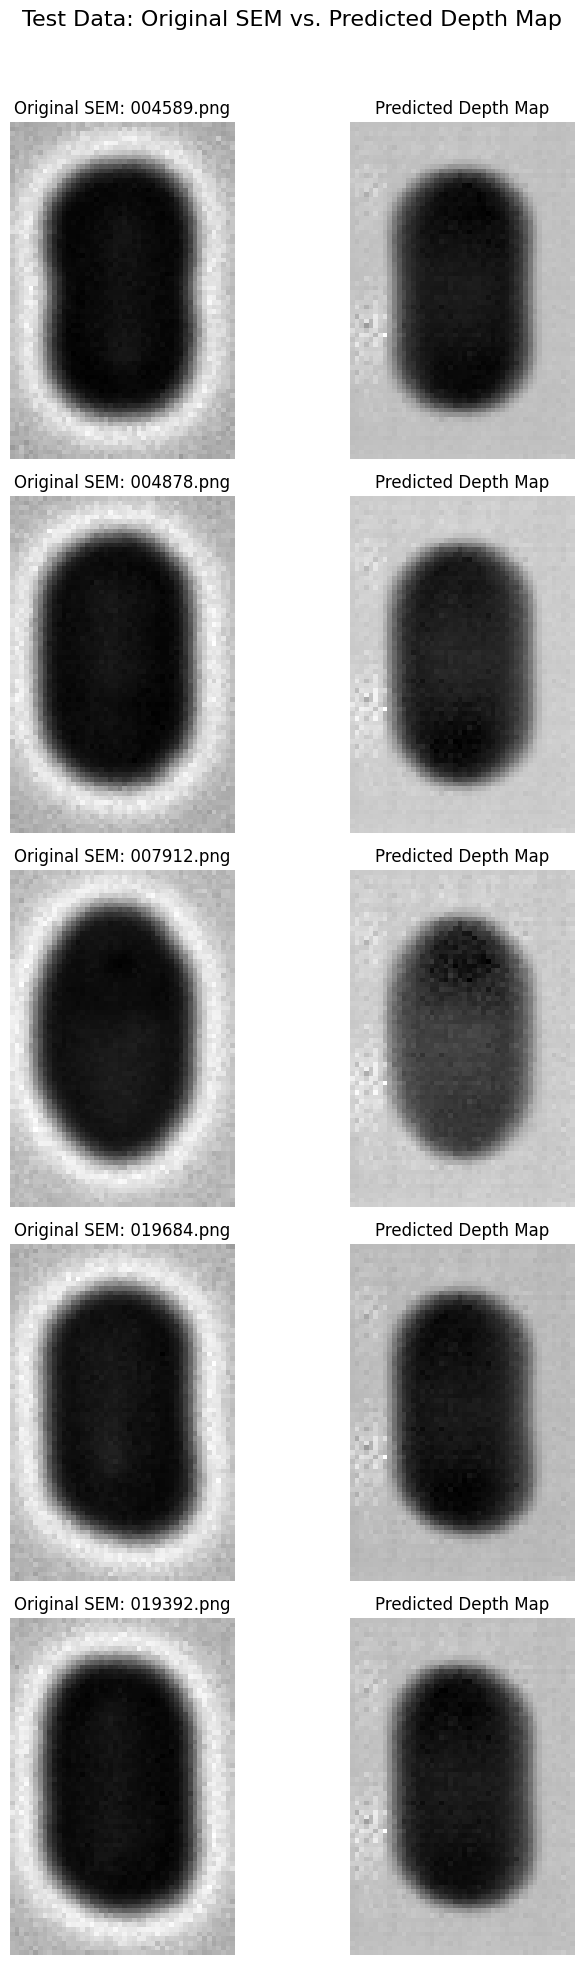

In [36]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import glob
import os
import PIL # <-- 이 줄을 추가했습니다!

def visualize_test_results(num_samples=5):
    """
    테스트 데이터셋에서 무작위로 샘플을 N개 선택하여
    원본 SEM 이미지와 모델이 예측한 Depth Map을 시각화합니다.
    """
    print("테스트 결과 시각화를 시작합니다...")

    # 1. 학습된 모델 파일 찾기
    project_path = "/content/drive/MyDrive/25_여름방학/삼성_공모전/"
    list_of_files = glob.glob(os.path.join(project_path, 'lightning_logs/version_*/checkpoints/*.ckpt'))
    if not list_of_files:
        print("✗ 에러: 학습된 모델 파일(.ckpt)을 찾을 수 없습니다. 모델을 먼저 학습시켜 주세요.")
        return
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"✓ 모델 로딩: {latest_file}")

    # 2. 모델 로드 및 평가 모드 설정
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = CAELightningModule.load_from_checkpoint(checkpoint_path=latest_file)
    model.to(device)
    model.eval()

    # 3. 테스트 데이터 경로 가져오기 및 무작위 샘플 선택
    test_sem_paths = sorted(glob.glob('/content/test/SEM/*.png'))

    if len(test_sem_paths) == 0:
        print(f"✗ 에러: '/content/test/SEM/' 폴더에서 이미지 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        return
    elif len(test_sem_paths) < num_samples:
        print(f"✓ 테스트 이미지 수가 요청한 샘플 수({num_samples})보다 적어 {len(test_sem_paths)}개만 시각화합니다.")
        num_samples = len(test_sem_paths)

    sample_paths = random.sample(test_sem_paths, num_samples)

    # 4. 시각화 준비
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))
    if num_samples == 1:
        axes = np.array([axes])
    fig.suptitle('Test Data: Original SEM vs. Predicted Depth Map', fontsize=16)

    # 5. 샘플에 대한 추론 및 시각화
    with torch.no_grad():
        for i, path in enumerate(sample_paths):
            dataset = TransformedDataset([path], None)
            loader = DataLoader(dataset, batch_size=1, shuffle=False)
            sem_tensor, _ = next(iter(loader))

            sem_tensor = sem_tensor.float().to(device)
            pred_tensor = model(sem_tensor)

            original_img = sem_tensor.squeeze().cpu().numpy()
            predicted_img = pred_tensor.squeeze().cpu().numpy()

            axes[i, 0].imshow(original_img, cmap='gray')
            axes[i, 0].set_title(f"Original SEM: {os.path.basename(path)}")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(predicted_img, cmap='gray')
            axes[i, 1].set_title(f"Predicted Depth Map")
            axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- 함수 실행 ---
visualize_test_results(num_samples=5)

In [29]:
# 'test' 폴더의 내용물을 확인해서 실제 이미지 경로를 찾아봅니다.
%cd /content/


%ls -R test

/content
test:
SEM/

test/SEM:
000000.png  004332.png  008664.png  012996.png  017328.png  021660.png
000001.png  004333.png  008665.png  012997.png  017329.png  021661.png
000002.png  004334.png  008666.png  012998.png  017330.png  021662.png
000003.png  004335.png  008667.png  012999.png  017331.png  021663.png
000004.png  004336.png  008668.png  013000.png  017332.png  021664.png
000005.png  004337.png  008669.png  013001.png  017333.png  021665.png
000006.png  004338.png  008670.png  013002.png  017334.png  021666.png
000007.png  004339.png  008671.png  013003.png  017335.png  021667.png
000008.png  004340.png  008672.png  013004.png  017336.png  021668.png
000009.png  004341.png  008673.png  013005.png  017337.png  021669.png
000010.png  004342.png  008674.png  013006.png  017338.png  021670.png
000011.png  004343.png  008675.png  013007.png  017339.png  021671.png
000012.png  004344.png  008676.png  013008.png  017340.png  021672.png
000013.png  004345.png  008677.png  013009.png

In [26]:
# Automated system
!python mcp_integrated.py --colab --auto

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py", line 6475, in <module>
    @_axis_nan_policy_factory(pack_TtestResult, default_axis=0, n_samples=2,
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py", line 658, in axis_nan_policy_decorator
    doc = FunctionDoc(axis_nan_policy_wrapper)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/scipy/_lib/_docscrape.py", line 589, in __init__
    NumpyDocString.__init__(self,

In [ ]:
# Debugging and testing

# Data only
!python mcp_integrated.py --detect-data

python3: can't open file '/content/mcp_integrated.py': [Errno 2] No such file or directory
